<a href="https://colab.research.google.com/github/BohdanLiuisk/neural-networks/blob/main/hybrid_sn_v1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 15.5 MB/s eta 0:00:00


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')

hsi_datasets_path = '/content/drive/My Drive/hsi_datasets'
hsi_datasets_local_path = '/content/dataset'
shutil.copytree(hsi_datasets_path, hsi_datasets_local_path)

print("Current working directory:", os.getcwd())
print("Files in the working directory:")
os.listdir('.')

Mounted at /content/drive
Current working directory: /content
Files in the working directory:


['.config', 'drive', 'dataset', 'sample_data']

Unique labels before to_categorical: [0 1 2 3 4 5 6 7 8]
Unique labels after encoding: [0 1 2 3 4 5 6 7 8]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 576)       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        331840    
                    

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
41/41 [==============================] - 22s 225ms/step - loss: 2.0584 - accuracy: 0.3575 - val_loss: 1.4383 - val_accuracy: 0.4258
Epoch 2/100
41/41 [==============================] - 8s 198ms/step - loss: 1.0502 - accuracy: 0.5987 - val_loss: 0.5284 - val_accuracy: 0.8212
Epoch 3/100
41/41 [==============================] - 8s 200ms/step - loss: 0.4048 - accuracy: 0.8591 - val_loss: 0.2207 - val_accuracy: 0.9299
Epoch 4/100
41/41 [==============================] - 9s 218ms/step - loss: 0.1424 - accuracy: 0.9536 - val_loss: 0.0660 - val_accuracy: 0.9786
Epoch 5/100
41/41 [==============================] - 8s 205ms/step - loss: 0.0576 - accuracy: 0.9836 - val_loss: 0.0534 - val_accuracy: 0.9794
Epoch 6/100
41/41 [==============================] - 8s 207ms/step - loss: 0.0306 - accuracy: 0.9911 - val_loss: 0.0163 - val_accuracy: 0.9953
Epoch 7/100
41/41 [==============================] - 9s 208ms/step - loss: 0.0177 - accuracy: 0.9953 - val_loss: 0.0116 - val_accuracy: 0.998

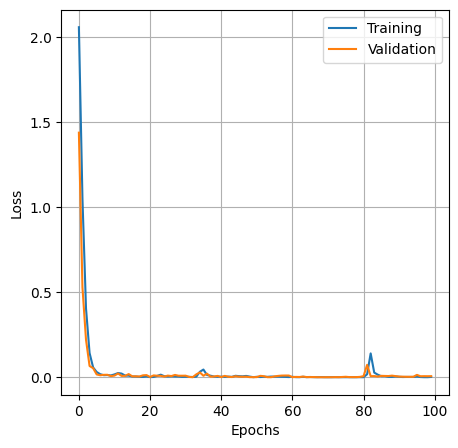

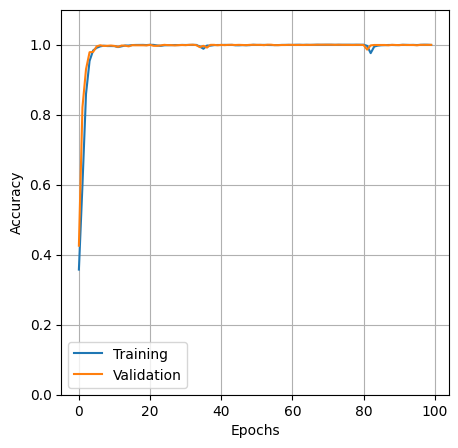

In [4]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv3D, Conv2D, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit

## GLOBAL VARIABLES
DATASET = 'PU'
TEST_RATIO = 0.7
WINDOW_SIZE = 25
DATA_PATH = '/content/dataset/'
MODEL_PATH = "/content/drive/MyDrive/trained_models/{}_hybrid_sn.h5".format(DATASET)

def load_data(name):
    if name == 'IP':
        data = sio.loadmat(os.path.join(DATA_PATH, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(DATA_PATH, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(DATA_PATH, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(DATA_PATH, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'SA_S':
        data = sio.loadmat(os.path.join(DATA_PATH, 'SalinasA_corrected.mat'))['salinasA_corrected']
        labels = sio.loadmat(os.path.join(DATA_PATH, 'SalinasA_gt.mat'))['salinasA_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(DATA_PATH, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(DATA_PATH, 'PaviaU_gt.mat'))['paviaU_gt']
    return data, labels

def apply_pca(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def pad_with_zeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def create_image_cubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = pad_with_zeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def plot_model_history(history):
    # Plotting the Loss Curve
    plt.figure(figsize=(5,5))
    plt.grid() 
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training','Validation'], loc='upper right')
    plt.savefig("loss_curve.png")
    plt.show()

    # Plotting the Accuracy Curve
    plt.figure(figsize=(5,5))
    plt.ylim(0,1.1)
    plt.grid() 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training','Validation'])
    plt.savefig("acc_curve.png")
    plt.show()

def build_model(input_shape, output_units):
    ## input layer
    input_layer = Input(input_shape)

    ## convolutional layers
    conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
    conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
    conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)

    conv3d_shape = tf.keras.backend.int_shape(conv_layer3)
    conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
    conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

    flatten_layer = Flatten()(conv_layer4)

    ## fully connected layers
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

    # Define the model and print the summary
    model = Model(inputs=input_layer, outputs=output_layer)
    model.summary()

    return model

def generate_image_cubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = pad_with_zeros(X, margin=margin)
    # generate patches
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patch_label = y[r-margin, c-margin]
            if removeZeroLabels and patch_label > 0:
                yield (patch, patch_label - 1)
            elif not removeZeroLabels:
                yield (patch, patch_label)

def train_test_split_generator(data, labels, test_size=0.3):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size)
    for train_index, test_index in splitter.split(data, labels):
        yield data[train_index], data[test_index], labels[train_index], labels[test_index]

if __name__ == '__main__':
    if not os.path.exists(MODEL_PATH):
        X, y = load_data(DATASET)
        K = 30
        X, _ = apply_pca(X, numComponents=K)
        patchesGenerator = generate_image_cubes(X, y, windowSize=WINDOW_SIZE)
        X_patches = []
        y_patches = []
        for (patch, label) in patchesGenerator:
            X_patches.append(patch)
            y_patches.append(label)
        X = np.array(X_patches)
        y = np.array(y_patches)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, stratify=y)
        X_train = X_train.reshape(-1, WINDOW_SIZE, WINDOW_SIZE, K, 1)
        print("Unique labels before to_categorical:", np.unique(y_train))
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        y_train = to_categorical(y_train_encoded)
        print("Unique labels after encoding:", np.unique(y_train_encoded)) 
        # Determine the number of unique classes
        output_units = len(np.unique(y_train_encoded))
        model = build_model((WINDOW_SIZE, WINDOW_SIZE, K, 1), output_units)
        #compiling the model
        adam = tf.keras.optimizers.legacy.Adam(lr=0.001, decay=1e-06)
        model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
        history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_split=0.2)
        model.save(MODEL_PATH)
        plot_model_history(history)
    else:
        print(f'Model {MODEL_PATH} already exists.')
